In [191]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [192]:
data = pd.read_csv("cleaned_data.csv")

In [193]:
data.shape

(142441, 13)

In [194]:
data.head()

,Unnamed: 0,REF_DATE,GEO,Traveller characteristics,Traveller type,VALUE,Year,Month,Province,Security_Level,Resident Type,Mode of Transport,Resident Category
0,1068630,2021-04-01,Midway,Canadian residents returning from the United S...,Tourists (overnight),0.0,2021,4,British Columbia,Moderate-Security,Canadian residents returning from the United S...,"water, ferry",Canadian Residents
1,2112956,2022-08-01,Ontario,Canadian residents returning from countries ot...,Tourists (overnight),0.0,2022,8,Ontario,Moderate-Security,Canadian residents returning from countries ot...,"air, private aircraft, direct",Canadian Residents
2,1240955,2021-07-01,Hamilton,Residents of countries other than the United S...,Tourists (overnight),0.0,2021,7,Ontario,Moderate-Security,Residents of countries other than the United S...,"land, vehicle type not available",Residents of Other Countries
3,157501,2020-03-01,St-Bernard-de-Lacolle: Highway 15,Residents of countries other than the United S...,Travellers,299.0,2020,3,Quebec,Moderate-Security,Residents of countries other than the United S...,"land, vehicle type not available",Residents of Other Countries
4,1987878,2022-06-01,Brockville,Canadian residents returning from countries ot...,Excursionists (same-day),0.0,2022,6,Ontario,Moderate-Security,Canadian residents returning from countries ot...,"water, private boat, direct",Canadian Residents


In [195]:
data['Resident Type'].unique()

array(['Canadian residents returning from the United States of America',
       'Canadian residents returning from countries other than the United States of America',
       'Residents of countries other than the United States of America',
       'Residents of countries other than the United States of America entering Canada',
       'United States of America residents', 'Crew,Canadian residents',
       'Other travellers entering or returning to Canada',
       'United States of America residents entering Canada',
       'Crew,United States of America residents',
       'Crew,Canadian residents returning to Canada',
       'Non-resident visitors entering Canada',
       'International travellers entering or returning to Canada',
       'Crew,United States of America residents entering Canada',
       'Crew,residents of countries other than the United States of America',
       'Crew entering or returning to Canada,Unknown',
       'Canadian-resident visitors returning to Canada',
    

# Analysis

## 1. Time Series Analysis: How has the number of travelers changed over time from 2020 - 2024?

In [196]:
# Convert 'REF_DATE' column to datetime format
data['REF_DATE'] = pd.to_datetime(data['REF_DATE'])

# Group the data by year and month and sum the number of travelers (VALUE)
data['Year-Month'] = data['REF_DATE'].dt.to_period('M')  # Create a 'Year-Month' column
monthly_travelers = data.groupby('Year-Month')['VALUE'].sum().reset_index()

# Convert 'YearMonth' to string for better handling in plotly
monthly_travelers['Year-Month'] = monthly_travelers['Year-Month'].astype(str)

# Create a plotly line chart
fig = px.line(monthly_travelers, x='Year-Month', y='VALUE', 
              title='Number of Travelers per Month',
              labels={'Year-Month': 'Month-Year', 'VALUE': 'Number of Travelers'},
              line_shape='linear')

# Adjust y-axis to display numbers in a readable format (e.g., avoiding scientific notation)
fig.update_layout(yaxis_tickformat=',')  # Use a comma to separate thousands

# Update x-axis to show month names properly
fig.update_xaxes(tickangle=45, tickmode='array')

# Show the plot
fig.show()


## 2. How have travel trends varied across Canadian provinces?

In [197]:
import plotly.express as px

# Convert 'REF_DATE' to datetime and extract year, month name, and month number
data['Month_Name'] = data['REF_DATE'].dt.month_name()

# Step 1: Overall travel trend by province and month
# Group data by province, year, and numeric month, and sum the number of travelers (VALUE)
monthly_travel_province = data.groupby(['Province', 'Year', 'Month', 'Month_Name'])['VALUE'].sum().reset_index()

# Sort by numeric 'Month' to ensure correct order
monthly_travel_province = monthly_travel_province.sort_values(['Year', 'Month'])

monthly_travel_province = monthly_travel_province[~monthly_travel_province['Province'].str.contains('Country', na=False)]

# Plot the overall travel trend by province and month
fig1 = px.line(monthly_travel_province, x='Month_Name', y='VALUE', color='Province', line_group='Year',
               title='Travel Trends Across Provinces Over Months',
               labels={'VALUE': 'Travelers', 'Month_Name': 'Month'},
               facet_col='Province', facet_col_wrap=3)

# Update layout for better visualization
fig1.update_layout(
    height=600, 
    yaxis_tickformat=',', 
    xaxis_tickangle=45, 
    yaxis_tickmode='array',  # This can help with controlling y-axis ticks
    yaxis_tickvals=[i * 5000 for i in range(0, 10)],  # Adjust the tick values range as necessary
    showlegend=True
)

# Reduce clutter by adjusting the x-axis tick label frequency
fig1.update_xaxes(tickmode='array', tickvals=['January', 'April', 'July', 'October'])

# Show the plot
fig1.show()


In [198]:
# Step 2: Travel activity by specific provinces (Ontario, Quebec, British Columbia)
selected_provinces = ['Ontario', 'Quebec', 'British Columbia']
province_travel_data = data[data['Province'].isin(selected_provinces)].groupby(
    ['Province', 'Year', 'Month', 'Month_Name']
)['VALUE'].sum().reset_index()

# Sort by year and month to ensure proper ordering
province_travel_data = province_travel_data.sort_values(['Year', 'Month'])

# Filter data for the years 2020, 2021, 2022, 2023, 2024
filtered_years = [2020, 2021, 2022, 2023, 2024]
province_travel_data = province_travel_data[province_travel_data['Year'].isin(filtered_years)]

# Create the line plot with different lines for each year and provinces as legend
fig2 = px.line(province_travel_data, 
              x='Month_Name', 
              y='VALUE', 
              color='Province',  # Provinces will be shown in the legend
              line_group='Year',  # Group the lines by year
              facet_row='Year',   # Create separate rows for each year
              title='Travel Activity in Ontario, Quebec, and British Columbia (2020-2024)',
              labels={'VALUE': 'Number of Travelers', 'Month_Name': 'Month'})

# Update layout for better visualization
fig2.update_layout(height=1000, yaxis_tickformat=',', xaxis_tickangle=45)

# Show the line chart
fig2.show()




## 3. How does the distribution of traveler types vary across different resident categories and over the years?

In [199]:
# Group data by Year, Resident Category, and Traveler Type and sum travelers (VALUE)
yearly_travel_comparison = data.groupby(['Year', 'Resident Category'])['VALUE'].sum().reset_index()

# Create a Pie chart for each year, showing distribution by Resident Category and Traveler Type
fig = px.pie(yearly_travel_comparison, 
             names='Resident Category', 
             values='VALUE',
             color='Resident Category',
             facet_col='Year', 
             facet_col_wrap=5,  # Set the number of charts per row, adjust as needed
             title='Traveler Distribution by Resident Category Across Years')

# Update layout to adjust spacing between pie charts and make it less clumsy
fig.update_layout(
    height=600,  # Adjust height for better spacing
    width=1200,  # Adjust width for better spacing
    showlegend=True,  # Show legend for clarity
    legend_title='Resident Category',  # Title for the legend
)

fig.show()



In [200]:
# Filter data for both Canadian Residents and Canadian Crew
resident_and_crew_data = data[data['Resident Category'].isin(['Canadian Residents', 'Canadian Crew'])]

# Ensure that 'Traveller type' column is not empty or null
resident_and_crew_data = resident_and_crew_data.dropna(subset=['Traveller type'])

# Combine Canadian Residents and Canadian Crew into one category
resident_and_crew_data['Resident Category'] = resident_and_crew_data['Resident Category'].replace({
    'Canadian Crew': 'Canadian Residents'})

# Group data by 'Resident Category' and 'Traveller type', and sum the 'VALUE' (number of travelers)
travel_type_distribution = resident_and_crew_data.groupby(['Resident Category', 'Traveller type'])['VALUE'].sum().reset_index()

# Create a Bar Plot for combined Canadian Residents and Canadian Crew
fig = px.bar(travel_type_distribution, 
             x='Traveller type', 
             y='VALUE',
             color='Traveller type',  # Different colors for different traveler types
             title='Traveler Type Distribution for Canadian Residents and Canadian Crew Combined',
             labels={'VALUE': 'Number of Travelers', 'Traveller type': 'Traveler Type'})

# Update layout for better visualization
fig.update_layout(
    height=600,
    width=800,
    showlegend=True,  # Show legend for clarity
    legend_title='Traveller Type',
    xaxis_title='Traveler Type',
    yaxis_title='Number of Travelers'
)

fig.show()

## 4. How did travel volumes shift across provinces during key phases of the pandemic?

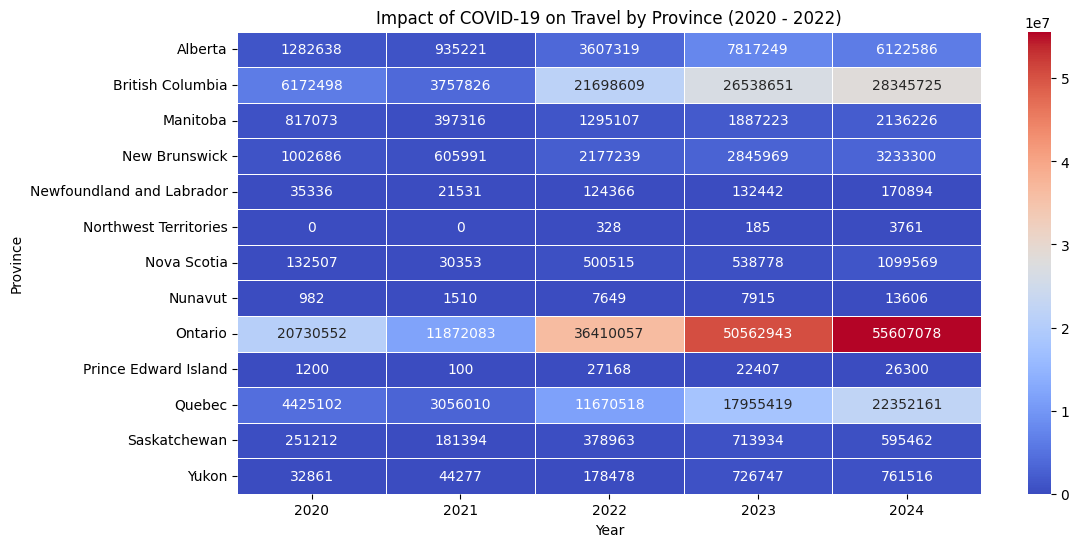

In [201]:
# Group data by Province and Year
regional_travel = data.groupby(['Province', 'Year'])['VALUE'].sum().reset_index()

# Pivot the data for heatmap format
heatmap_data = regional_travel.pivot(index='Province', columns='Year', values='VALUE')

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5)

# Titles and labels
plt.title("Impact of COVID-19 on Travel by Province (2020 - 2022)")
plt.xlabel("Year")
plt.ylabel("Province")

plt.show()

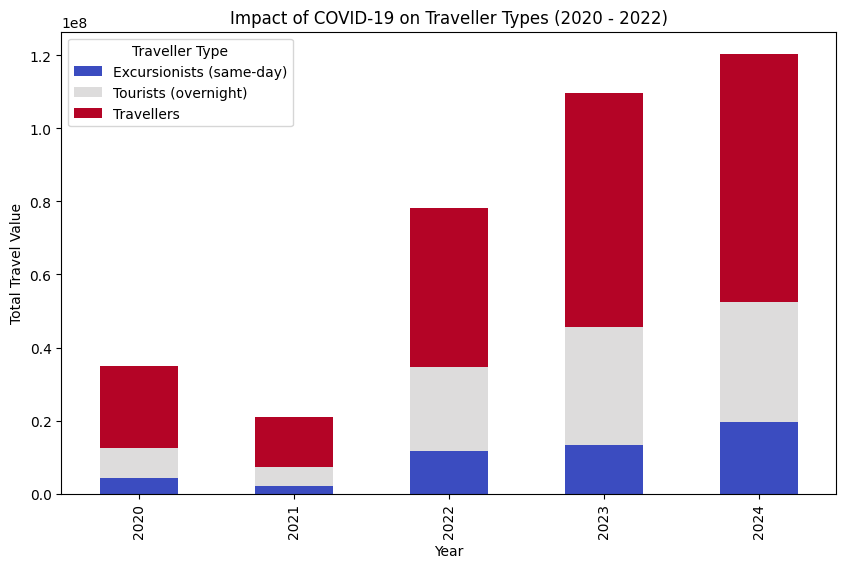

In [202]:
# Group by Traveller Type and Year
traveller_type_travel = data.groupby(['Traveller type', 'Year'])['VALUE'].sum().reset_index()

# Pivot the data
pivot_df = traveller_type_travel.pivot(index='Year', columns='Traveller type', values='VALUE')

# Plot a stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')

# Titles and labels
plt.title("Impact of COVID-19 on Traveller Types (2020 - 2022)")
plt.xlabel("Year")
plt.ylabel("Total Travel Value")

plt.legend(title="Traveller Type")
plt.show()

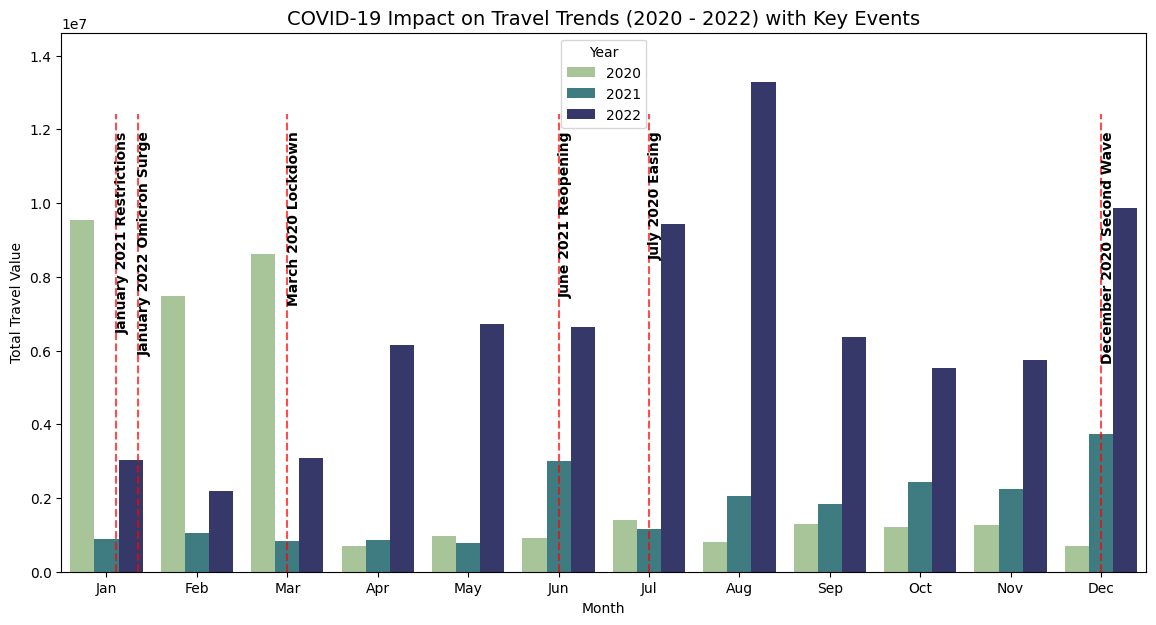

In [203]:
# Define major lockdown events (adjust based on actual data)
lockdown_dates = {
    'March 2020 Lockdown': ('2020', 3),
    'July 2020 Easing': ('2020', 7),
    'December 2020 Second Wave': ('2020', 12),
    'January 2021 Restrictions': ('2021', 1.1),  # Slightly shifted
    'June 2021 Reopening': ('2021', 6),
    'January 2022 Omicron Surge': ('2022', 1.35)  # Slightly shifted
}

# Filter dataset to include only 2020-2022
df_filtered = data[data['Year'].between(2020, 2022)]

# Aggregate monthly travel data
monthly_travel = df_filtered.groupby(['Year', 'Month'])['VALUE'].sum().reset_index()

# Create the bar plot
plt.figure(figsize=(14, 7))
sns.barplot(data=monthly_travel, x='Month', y='VALUE', hue='Year', palette='crest')

# Set a fixed upper limit to avoid overlap
plt.ylim(0, monthly_travel['VALUE'].max() * 1.1)  

# Add lockdown markers with red lines and dark text
for event, (year, month) in lockdown_dates.items():
    if year in ['2020', '2021', '2022']:  # Ensure only events from 2020-2022 are shown
        y_position = monthly_travel['VALUE'].max() * 0.9  # Lowered text placement
        plt.axvline(x=month - 1, color='red', linestyle='--', alpha=0.7, ymax=0.85)  # Red line
        plt.text(month - 1, y_position, event, rotation=90, color='black', fontsize=10, va='top', fontweight='bold')  # Darker text

# Titles and labels
plt.title("COVID-19 Impact on Travel Trends (2020 - 2022) with Key Events", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Total Travel Value")
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.legend(title="Year")
plt.show()

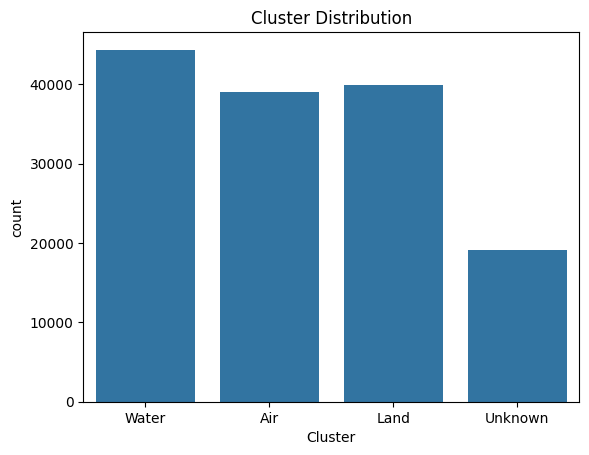

In [204]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Use TF-IDF to convert the text data to numerical vectors
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)  # Limit to top 1000 features for efficiency
tfidf_matrix = tfidf.fit_transform(data['Mode of Transport'])

# 2. Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(tfidf_matrix)

cluster_mapping = {0: 'Water', 1: 'Unknown', 2: 'Air', 3: 'Land'}
data['Cluster'] = data['Cluster'].replace(cluster_mapping)


# 3. Visualize the clusters using count plot
sns.countplot(x='Cluster', data=data)  # `data=df` and reference to `Cluster` column
plt.title('Cluster Distribution')
plt.show()



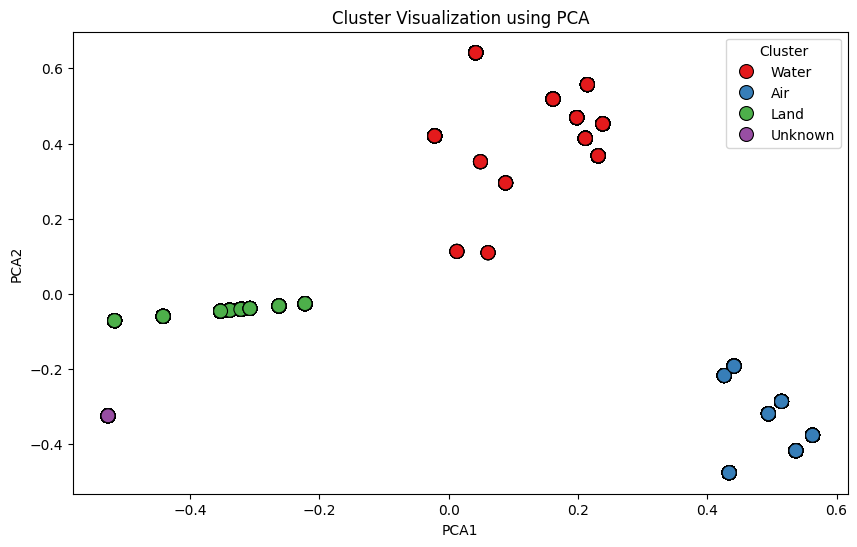

In [205]:
from sklearn.decomposition import PCA

# 1. Reduce the dimensionality of the TF-IDF matrix to 2D using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(tfidf_matrix.toarray())  # Convert sparse matrix to array for PCA

# 2. Add the PCA components to the dataframe for plotting
data['PCA1'] = pca_components[:, 0]
data['PCA2'] = pca_components[:, 1]

# 3. Scatter plot of the clusters based on PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data, palette='Set1', s=100, edgecolor='black')
plt.title('Cluster Visualization using PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

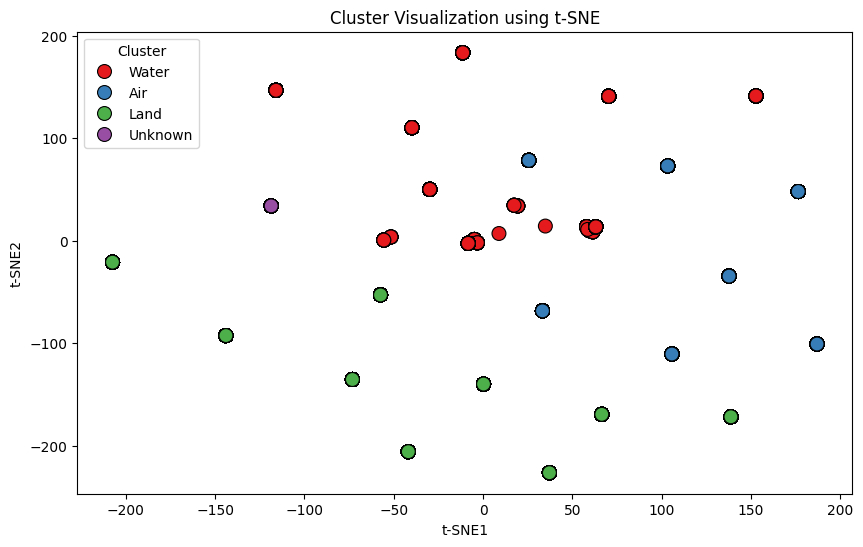

In [206]:
# If you want to plot the original high-dimensional clusters directly, use the first two features
# We will use a method like t-SNE (another dimensionality reduction technique) for 2D visualization
from sklearn.manifold import TSNE

# 1. Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(tfidf_matrix.toarray())  # Convert sparse matrix to array for t-SNE

# 2. Add the t-SNE components to the dataframe for plotting
data['TSNE1'] = tsne_components[:, 0]
data['TSNE2'] = tsne_components[:, 1]

# 3. Scatter plot of the clusters based on t-SNE components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=data, palette='Set1', s=100, edgecolor='black')
plt.title('Cluster Visualization using t-SNE')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend(title='Cluster')
plt.show()

In [173]:
import pandas as pd
import plotly.express as px

# Convert 'REF_DATE' column to datetime format
data['REF_DATE'] = pd.to_datetime(data['REF_DATE'])

# Create 'Year-Month' column
data['Year-Month'] = data['REF_DATE'].dt.to_period('M').astype(str)  # Convert to string for Plotly
# Remove rows with Cluster 'Cluster_B' (formerly 1)
data = data[data['Cluster'] != 'Unknown']

# Group by 'Year-Month' and 'Cluster' and sum the number of travelers
monthly_travelers = data.groupby(['Year-Month', 'Cluster'])['VALUE'].sum().reset_index()

# Create a plotly line chart with 'Cluster' as the legend
fig = px.line(monthly_travelers, x='Year-Month', y='VALUE', color='Cluster',
              title='Number of Travelers per Month (Cluster-wise)',
              labels={'Year-Month': 'Month-Year', 'VALUE': 'Number of Travelers', 'Cluster': 'Transport Cluster'},
              line_shape='linear')

# Adjust y-axis to display numbers in a readable format (avoid scientific notation)
fig.update_layout(yaxis_tickformat=',', xaxis_tickangle=45)

# Show the plot
fig.show()

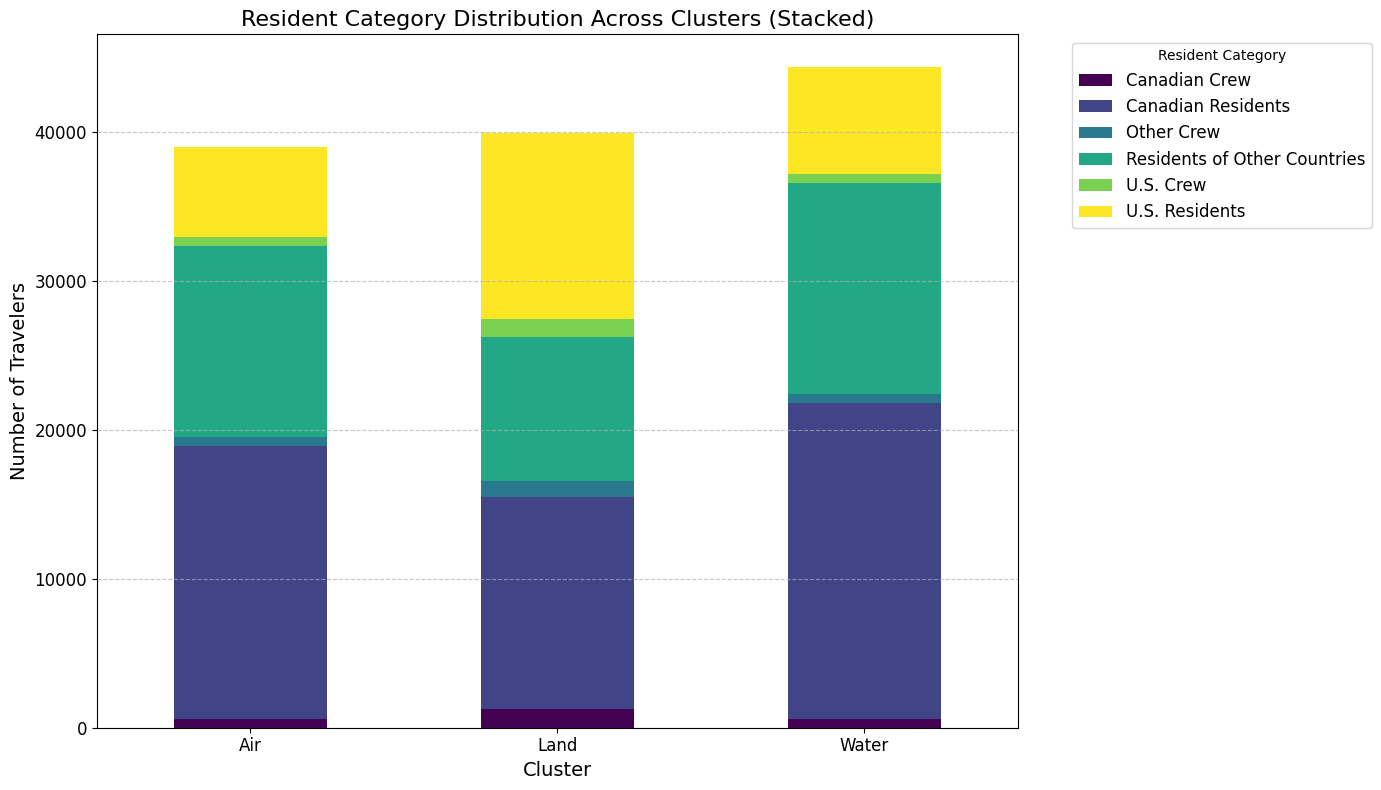

In [174]:
# Count occurrences of Resident Category within each Cluster
resident_cluster_counts = pd.crosstab(data['Cluster'], data['Resident Category'])

# Plot stacked bar chart
resident_cluster_counts.plot(kind='bar', stacked=True, figsize=(14,8), colormap='viridis')

# Formatting the plot
plt.title("Resident Category Distribution Across Clusters (Stacked)", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Number of Travelers", fontsize=14)
plt.xticks(rotation=0, fontsize=12)  # Keep x-axis labels horizontal for better readability
plt.yticks(fontsize=12)

# Move legend to the side to avoid overlap
plt.legend(title="Resident Category", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to fit everything properly
plt.tight_layout()

# Show the plot
plt.show()

In [175]:
from sklearn.model_selection import train_test_split

# Example of splitting your data into training and testing sets
X = data.drop(['VALUE','Month','Province','Mode of Transport','Resident Category','Resident Type'], axis=1)
y = data['Traveller type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [176]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Use the pre-defined feature_cols from X_train
feature_cols = X_train.columns.drop('Traveller type', errors='ignore')

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert datetime columns to numerical format (ordinal or extract year/month)
if 'REF_DATE' in feature_cols:
    X_train['REF_DATE'] = X_train['REF_DATE'].apply(lambda x: x.toordinal())
    X_test['REF_DATE'] = X_test['REF_DATE'].apply(lambda x: x.toordinal())

# Convert problematic columns to category dtype or encode object types
for col in ['GEO', 'Traveller characteristics', 'Security_Level', 'Year-Month', 'Month_Name', 'Cluster']:
    if col in feature_cols:
        if X_train[col].dtype == 'object':
            X_train[col] = X_train[col].astype('category')  # Convert object to category
            X_test[col] = X_test[col].astype('category')

clf_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', enable_categorical=True)

# Fit the model
clf_xgb.fit(X_train[feature_cols], y_train_encoded)

# Make predictions
y_pred_class = clf_xgb.predict(X_test[feature_cols])
y_pred_labels = label_encoder.inverse_transform(y_pred_class)

# Print classification report and accuracy
print(classification_report(y_test, y_pred_labels))
print("Accuracy:", accuracy_score(y_test, y_pred_labels))

                          precision    recall  f1-score   support

Excursionists (same-day)       0.32      0.32      0.32      7627
    Tourists (overnight)       0.33      0.32      0.33      7733
              Travellers       0.43      0.44      0.43      9294

                accuracy                           0.36     24654
               macro avg       0.36      0.36      0.36     24654
            weighted avg       0.36      0.36      0.36     24654

Accuracy: 0.36460614910359374
